In [1]:
# load packages and set working directory
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import os
os. getcwd()
os. chdir('/w5home/bmoore/scFoundation/annotation/')
os. getcwd()

'/mnt/cephfs/mir/rstewart/stewart-lab/isi5home/bmoore/scFoundation/annotation'

In [53]:
# load ann data to get labels
adata = sc.read_h5ad("/w5home/bmoore/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/GAMM_S2_clabeled-clusters_0.5.h5ad")
print(len(adata.obs))

19313


/w5home/bmoore/miniconda3/envs/scfound2/lib/python3.12/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
# load embeddings and add labels
import anndata

# Load the embeddings from the .npy file
embeddings = np.load('../Gamm_cell_embed/Gamm_01B-resolution_singlecell_cell_embedding_a5_resolution_lognorm.npy')

# Extract the labels
labels = adata.obs['CellType_manual'].values

# Check if the number of embeddings matches the number of labels
assert embeddings.shape[0] == labels.shape[0], "Number of embeddings does not match number of labels."

# Combine the embeddings and labels into a dictionary
data = {
    'embeddings': embeddings,
    'labels': labels
}

# Save the combined data as a pickle file
with open('Gamm_01B-resolution_singlecell_cell_embedding_a5_resolution_lognorm_withlabels.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Embeddings and labels have been successfully combined and saved as a pickle file.")


Embeddings and labels have been successfully combined and saved as a pickle file.


In [102]:
# train without cross-validation

import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the embeddings and cell types from the pickle file
with open('Gamm_01B-resolution_singlecell_cell_embedding_a5_resolution_lognorm_withlabels.pkl', 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings']  # Shape: (n_samples, n_features)
labels = data['labels']  # Shape: (n_samples,)
indices = list(range(len(labels)))
indices = np.array(indices)
# Filter out entries with the label 'unknown'
mask = labels != 'unknown'
print(mask)

embeddings_filtered = embeddings[mask]
labels_filtered = labels[mask]
indices_filtered = indices[mask]

# Split the filtered data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    embeddings_filtered, labels_filtered, indices_filtered, test_size=0.2, random_state=42
)

# Initialize a classifier (e.g., Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

print(f'Accuracy: {accuracy}')
print(f'Classification Report DataFrame:\n{report_df}')

# Save the classification report to a CSV file if needed
report_df.to_csv('classification_report_noCV.csv')

[ True  True  True ...  True  True  True]
Accuracy: 0.954507628294036
Classification Report DataFrame:
                            precision    recall  f1-score      support
Amacrine cells               0.920455  0.910112  0.915254   267.000000
Bipolar Cells                0.977143  0.777273  0.865823   220.000000
Cones                        0.981132  0.504854  0.666667   103.000000
Muller Glia                  0.966102  0.966102  0.966102   118.000000
Muller Glia - Retinal Prog   0.965517  0.987552  0.976410   482.000000
Retinal Prog                 0.982759  0.780822  0.870229    73.000000
Rods                         0.952931  0.997407  0.974662  2314.000000
Rods - Muller Glia           0.909091  0.714286  0.800000    28.000000
accuracy                     0.954508  0.954508  0.954508     0.954508
macro avg                    0.956891  0.829801  0.879393  3605.000000
weighted avg                 0.955187  0.954508  0.951302  3605.000000


In [7]:
# Run with cross validation grid search- this takes a long time!!
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# # Load the embeddings and cell types from the pickle file
# with open('your_file.pkl', 'rb') as f:
#     data = pickle.load(f)

# Assuming 'data' is a dictionary with 'embeddings' and 'labels'
embeddings = data['embeddings']  # Shape: (n_samples, n_features)
labels = data['labels']  # Shape: (n_samples,)
indices = list(range(len(labels)))
indices = np.array(indices)

# remove unknowns
mask = labels != 'unknown'
embeddings_filtered = embeddings[mask]
labels_filtered = labels[mask]
indices_filtered = indices[mask]

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # n_jobs sets # of cpus

# Fit GridSearchCV
grid_search.fit(embeddings_filtered, labels_filtered)

# Get the best model
best_model = grid_search.best_estimator_

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_}')

# Proceed with training the best model on the entire dataset (optional)
best_model.fit(embeddings_filtered, labels_filtered)

# If you want to split into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    embeddings_filtered, labels_filtered, indices_filtered, test_size=0.2, random_state=42
)

# Train the best model on the training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

print(f'Accuracy: {accuracy}')
print(f'Classification Report DataFrame:\n{report_df}')

# Save the classification report to a CSV file if needed
report_df.to_csv('classification_report.csv')



In [105]:
#display(test_indices, y_pred)
# y_test = pd.Series(y_test)
# y_test.index
test_indices[1:]

array([6351, 4722, 4990, ..., 5935, 8780, 4025])

In [106]:
# Check if the number of test embeddings matches the number of predictions
assert len(y_pred) == X_test.shape[0], "Number of predictions does not match the number of test embeddings."

# Ensure the length of test_indices matches the length of y_pred
assert len(test_indices) == len(y_pred), "The number of test indices does not match the number of predictions."

# # subset test data
print(adata.obs.index[test_indices])
adata_subset = adata[adata.obs.index[test_indices],]

print(adata_subset)
# # add predicted data to ann object
adata_subset.obs["scfound_pred_noCV"] = pd.Categorical(y_pred)

Index(['CCTACGTCAACAGAGC_1', 'GTATTTCAGGCGATAC_1', 'GAACACTCATGTAACC_1',
       'GACTTCCGTCGCTTAA_1', 'GTGGAAGCAACAGCCC_2', 'TGGAACTGTTCTCGCT_1',
       'CTCTGGTGTTTCACAG_2', 'AGGGTTTGTAGTATAG_2', 'GTTCCGTAGATTGACA_2',
       'GTAATGCCAAACTCGT_1',
       ...
       'ACAACCAAGGTAAGTT_1', 'CGAAGGAAGTATGAAC_1', 'TAAGCACTCTGTGCGG_2',
       'AACAAGACATAGGTTC_1', 'AAAGGTACAGACGATG_2', 'ACATCGATCGAACCAT_2',
       'AGGTGTTCATCATTTC_2', 'GGGATCCGTATAGCTC_1', 'TGTAACGAGTACAACA_1',
       'CTACCCAGTGAGCAGT_1'],
      dtype='object', length=3605)
View of AnnData object with n_obs × n_vars = 3605 × 31781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual', 'scfound_pred_noCV'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

/tmp/ipykernel_26810/2005794555.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs["scfound_pred_noCV"] = pd.Categorical(y_pred)


In [107]:
set(adata_subset.obs.scfound_pred_noCV)

{'Amacrine cells',
 'Bipolar Cells',
 'Cones',
 'Muller Glia',
 'Muller Glia - Retinal Prog',
 'Retinal Prog',
 'Rods',
 'Rods - Muller Glia'}

<Figure size 600x500 with 0 Axes>

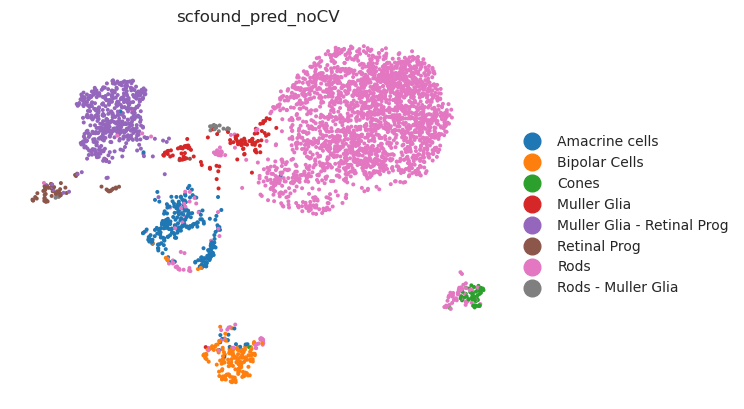

In [108]:
import seaborn as sns
sns.set_style("whitegrid")
# visualize predictions
import matplotlib.pyplot as plt
import random
%matplotlib inline
# view subset of data with predictions
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(6,5)) 
sc.pl.embedding(
    adata_subset,
    basis="umap",
    frameon=False,
    color='scfound_pred_noCV',
)
